# 1. Set Environment

In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# https://drive.google.com/file/d/142onsA72meq-7g02yOauJ6vWUZ8MxM43/view?usp=sharing
id = "142onsA72meq-7g02yOauJ6vWUZ8MxM43"
file = drive.CreateFile({'id':id})
file.GetContentFile('kaggle.json')
!pip install -q kaggle
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d gpiosenka/100-bird-species
!unzip 100-bird-species.zip

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import time
import os
import tqdm
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla T4


# 2. Load Data

In [ ]:
dataset_dir = "/content/"

width, height = 224, 224
train_tfms = transforms.Compose([transforms.Resize((width, height)),
                  transforms.RandomHorizontalFlip(),
                  transforms.RandomRotation(15),
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
valid_tfms = transforms.Compose([transforms.Resize((width, height)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_tfms = transforms.Compose([transforms.Resize((width, height)),
                  transforms.ToTensor(),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
bsize = 32

# create datasets
dataset = torchvision.datasets.ImageFolder(root=dataset_dir + "train", transform=train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=bsize, shuffle=True, num_workers=2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"valid", transform = valid_tfms)
validloader = torch.utils.data.DataLoader(dataset2, batch_size=bsize, shuffle=True, num_workers=2)

dataset3 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset3, batch_size=bsize, shuffle=False, num_workers=2)

# 3. Model Functions

## Training Function

In [ ]:
def train_model(model, criterion, optimizer, scheduler, n_epochs=5):

    losses = []
    accuracies = []
    valid_accuracies = []

    # set the model to train mode initially
    model.train()
    for epoch in tqdm.tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100.0 / bsize * running_correct / len(trainloader)
        print("\nEpoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))

        losses.append(epoch_loss)
        accuracies.append(epoch_acc)

        # switch the model to eval mode
        model.eval()
        valid_acc = eval_model(model)
        valid_accuracies.append(valid_acc)

        # re-set the model to train mode
        model.train()
        scheduler.step(valid_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, valid_accuracies

## Validation Function

In [ ]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(validloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    valid_acc = 100.0 * correct / total
    print('\nAccuracy of the network on the valid images: %.4f %%' % (
        valid_acc))
    return valid_acc

# 4. Experiment

## Define Parameters

In [ ]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(dataset_dir+"train")

In [ ]:
NUM_BIRD_CLASSES = len(classes)

model_ft = models.resnet34(pretrained=True)
# model_ft = models.alexnet(pretrained=True)

# for param in model_ft.parameters():
#     param.require_grad = False

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, NUM_BIRD_CLASSES)
# num_ftrs = model_ft.classifier[6].in_features
# model_ft.classifier[6] = nn.Linear(num_ftrs, NUM_BIRD_CLASSES)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 189MB/s]


## Model Training

In [ ]:
model_ft, training_losses, training_accs, valid_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1, duration: 439 s, loss: 2.9918, acc: 52.5390


 20%|██        | 1/5 [07:25<29:41, 445.25s/it]


Accuracy of the network on the valid images: 87.6190 %

Epoch 2, duration: 428 s, loss: 0.7661, acc: 86.6931


 40%|████      | 2/5 [14:40<21:58, 439.45s/it]


Accuracy of the network on the valid images: 92.7238 %

Epoch 3, duration: 431 s, loss: 0.4359, acc: 91.6871


 60%|██████    | 3/5 [21:57<14:36, 438.45s/it]


Accuracy of the network on the valid images: 94.9333 %

Epoch 4, duration: 429 s, loss: 0.3081, acc: 93.9095


 80%|████████  | 4/5 [29:12<07:17, 437.04s/it]


Accuracy of the network on the valid images: 96.2286 %

Epoch 5, duration: 434 s, loss: 0.2344, acc: 95.4171


100%|██████████| 5/5 [36:32<00:00, 438.59s/it]


Accuracy of the network on the valid images: 96.4952 %
Finished Training


## Evaluate the Model

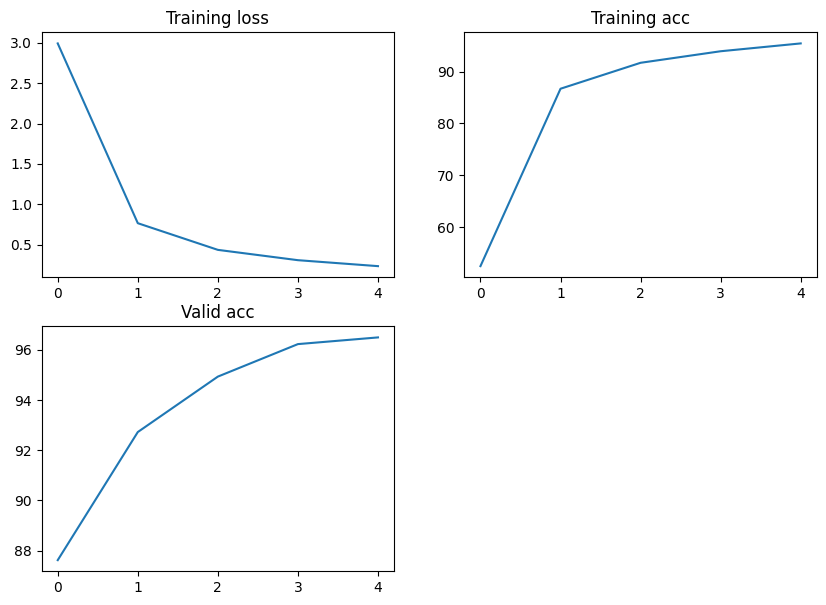

In [ ]:
f, axarr = plt.subplots(2,2, figsize = (10, 7))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(valid_accs)
axarr[1, 0].set_title("Valid acc")
plt.delaxes(axarr[1,1])

In [ ]:
def test_model(model):
  model.eval()
  correct = 0.0
  total = 0.0
  with torch.no_grad():
      for i, data in enumerate(testloader, 0):
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)

          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)

          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  test_acc = 100.0 * correct / total
  print('\nAccuracy of the network on the test images: %.4f %%' % (
      test_acc))
  return test_acc

test_acc = test_model(model_ft)


Accuracy of the network on the test images: 98.0190 %


In [ ]:
def predict(path):
  model_ft.eval()
  loader = transforms.Compose([transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  image = Image.open(path)
  image = loader(image).float()
  image = torch.autograd.Variable(image, requires_grad=True)
  image = image.unsqueeze(0)
  image = image.cuda()
  output = model_ft(image)
  conf, predicted = torch.max(output.data, 1)
  display(Image.open(path))
  print(f'Prediction: {classes[predicted.item()]} | Confidence: {conf.item()}')

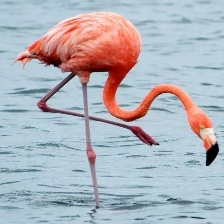

Prediction: AMERICAN FLAMINGO | Confidence: 17.07437515258789


In [ ]:
predict('/content/test/AMERICAN FLAMINGO/4.jpg')

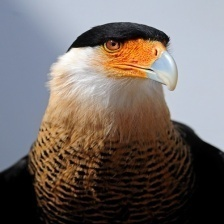

Prediction: CRESTED CARACARA | Confidence: 12.991406440734863


In [ ]:
predict('/content/test/CRESTED CARACARA/4.jpg')